# FXHash vs Hash Performance Analysis
This notebook analyzes benchmark results comparing FXHash and Hash performance over 10 runs with n=100.

In [7]:
import os
import json
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

def load_estimate(path: str) -> float:
    """
    estimates.json から mean の point_estimate(ns) を取得する
    Parameters
    ----------
    path : str
        estimates.json へのパス
    Returns
    -------
    float
        平均実行時間（ナノ秒）
    """
    with open(path, "r") as f:
        data = json.load(f)
    return data["mean"]["point_estimate"]

results = []
for run_dir in sorted(glob.glob("run_*")):
    for hash_dir in ("FxHashMap insert (String keys)",
                     "std HashMap insert (String keys)"):
        # new/ が無ければ base/ を見る
        for sub in ("new", "base"):
            est_path = os.path.join(run_dir, hash_dir, sub, "estimates.json")
            if os.path.exists(est_path):
                duration_ns = load_estimate(est_path)
                results.append({
                    "run": run_dir,
                    "hash_type": "FXHash" if hash_dir.startswith("FxHash") else "Hash",
                    "duration_ns": duration_ns
                })
                break  # new があれば base は読まない

df = pd.DataFrame(results)

## Data Processing and Statistical Analysis

In [8]:
# Calculate statistics per hash type
stats = df.groupby('hash_type').agg({
    'duration_ns': ['mean', 'std', 'min', 'max']
}).round(2)

stats.columns = ['mean_ns', 'std_ns', 'min_ns', 'max_ns']
stats = stats.reset_index()
stats

,hash_type,mean_ns,std_ns,min_ns,max_ns
0,FXHash,21130101.79,628624.44,20331132.70,23455026.89
1,Hash,26230175.17,872770.45,25390820.18,30414390.28


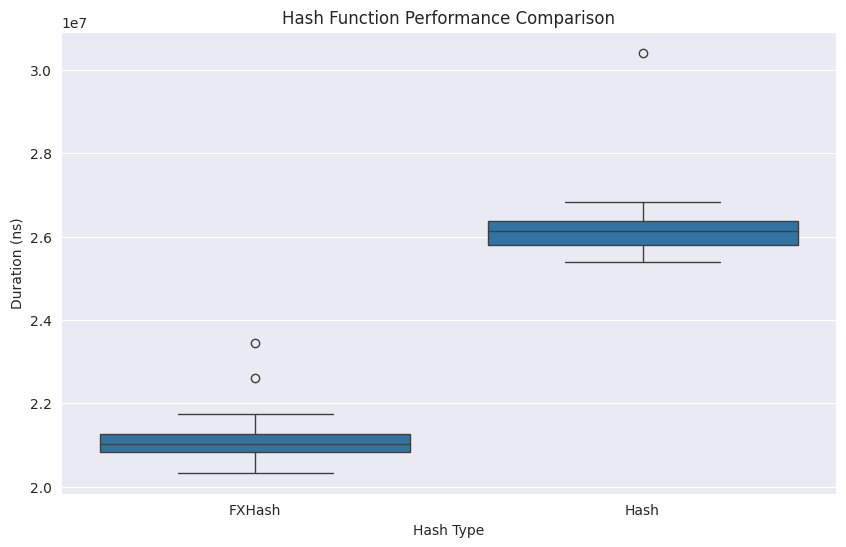

In [9]:
# Create box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='hash_type', y='duration_ns')
plt.title('Hash Function Performance Comparison')
plt.xlabel('Hash Type')
plt.ylabel('Duration (ns)')
plt.show()

## Performance Difference Analysis

In [10]:
# Calculate performance difference 
fxhash_mean = df[df['hash_type'] == 'FXHash']['duration_ns'].mean()
hash_mean = df[df['hash_type'] == 'Hash']['duration_ns'].mean()
diff_percent = ((hash_mean - fxhash_mean) / fxhash_mean * 100).round(2)

print(f"FXHash mean duration: {fxhash_mean:.2f} ns")
print(f"Hash mean duration: {hash_mean:.2f} ns")
print(f"Performance difference: {diff_percent}%")

FXHash mean duration: 21130101.79 ns
Hash mean duration: 26230175.17 ns
Performance difference: 24.14%


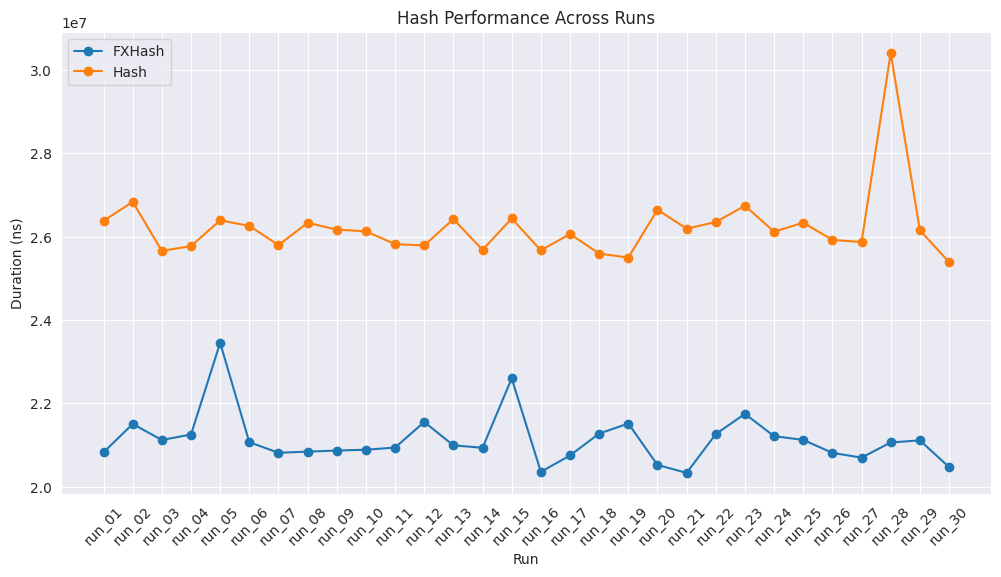

In [11]:
# Plot performance across runs
plt.figure(figsize=(12, 6))
for hash_type in df['hash_type'].unique():
    data = df[df['hash_type'] == hash_type]
    plt.plot(data['run'], data['duration_ns'], 'o-', label=hash_type)

plt.title('Hash Performance Across Runs')
plt.xlabel('Run')
plt.ylabel('Duration (ns)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## Execution Environments

This analysis was run with:

In [13]:
%%bash
echo "=== System Information ==="
uname -a
echo
echo "=== CPU Info ==="
lscpu | grep "Model name\|CPU(s)\|Thread(s) per core"
echo
echo "=== Memory Info ==="
free -h
echo
echo "=== Python Version ==="
python --version
echo
echo "=== UV Version ==="
uv --version
echo
echo "=== Rustc Version ==="
rustc --version
echo
echo "=== Jupyter Version ==="
jupyter --version


=== System Information ===
Linux fedora 6.14.6-300.fc42.x86_64 #1 SMP PREEMPT_DYNAMIC Fri May  9 20:11:19 UTC 2025 x86_64 GNU/Linux

=== CPU Info ===
CPU(s):                               4
On-line CPU(s) list:                  0-3
Model name:                           Intel(R) Core(TM) i3-8130U CPU @ 2.20GHz
Thread(s) per core:                   2
CPU(s) scaling MHz:                   79%
NUMA node0 CPU(s):                    0-3

=== Memory Info ===
               total        used        free      shared  buff/cache   available
Mem:            31Gi       8.1Gi       1.4Gi       761Mi        22Gi        23Gi
Swap:          8.0Gi       1.7Mi       8.0Gi

=== Python Version ===
Python 3.9.22

=== UV Version ===
uv 0.6.17

=== Rustc Version ===
rustc 1.86.0 (05f9846f8 2025-03-31)

=== Jupyter Version ===
Selected Jupyter core packages...
IPython          : 8.18.1
ipykernel        : 6.29.5
ipywidgets       : not installed
jupyter_client   : 8.6.3
jupyter_core     : 5.7.2
jupyter_server  